In [109]:
import matplotlib.pyplot as plt
import numpy as np
import sys, os

from pathlib import Path
sys.path.append(str(Path(os.getcwd()).parent))

from amo.constants import h, mK, hbar

import pandas as pd
from general.dat_helper import group_by_mean

print(os.getcwd())

from general.plot_settings import paper_settings, generate_plt_styles, colors
plt.rcParams.update(paper_settings)
# colors = colors[2:]
colors = ['teal', 'magenta']
# styles = [generate_plt_styles(colors=['teal'], ts=0.7)[0], 
#           generate_plt_styles(colors=['magenta'], ts=0.6)[0]]
styles = generate_plt_styles(colors=colors, ts=0.7)
plt.rcParams['lines.markersize'] = 4
plt.rcParams['legend.fontsize'] = 7

c:\Users\coldatoms\Documents\cjdGitHub\ChiPyLab\examples


In [110]:
files = ["2024-05-13_C_breathing_mode.dat",
         "2024-05-13_D_breathing_mode.dat",
         "2024-05-13_G_breathing_mode.dat",
         ]

# files = [files[0], files[-1]]

data_folder = os.path.join("..", "data", "trap_frequencies")
# files = glob(os.path.join(data_folder, + file_suffix))

dfs = []
for file in files:
    file = os.path.join(data_folder, file)
    dfs.append(pd.read_table(file, delimiter=',')) # making dataframe of chosen data

print(dfs[0].columns)
# print(dfs[1].columns)

for df, file in zip(dfs, files):
    print(file, len(df))

px_to_um = 3.0

for df in dfs:
    df['G_sigma_x'] = df['G_sigma_x'] * px_to_um
    df['G_sigma_y'] = df['G_sigma_y'] * px_to_um
    df['G_ctr_x'] = df['G_ctr_x'] * px_to_um
    df['G_ctr_y'] = df['G_ctr_y'] * px_to_um


scan_name = 'time'
df_y = group_by_mean(dfs[0], scan_name)
df_x = group_by_mean(dfs[2], scan_name)

Index(['cyc', 'time', 'y2 piezo', 'cyc.1', 'ROIsum', 'fBg', 'fA1', 'fWidth1',
       'fCtr1', 'fA2', 'fWidth2', 'fCtr2', 'box1', 'box2', 'box3', 'box4',
       'box5', 'box6', 'box7', 'box8', 'box9', 'Nfit', 'BZ-2', 'BZ-1', 'BZ0',
       'BZ1', 'BZ2', 'Excited', 'c5', 'c7', 'c9', 'fraction95', 'fraction75',
       'fraction97', 'sum95', 'Tx', 'Ty', 'LiToTF', 'LiNfit', 'TFcalc',
       'ToTFcalc', 'G_ctr_x', 'G_ctr_y', 'G_sigma_x', 'G_sigma_y', 'G_ar',
       'G_Tx', 'G_Ty', 'G_ToTFcalc'],
      dtype='object')
2024-05-13_C_breathing_mode.dat 156
2024-05-13_D_breathing_mode.dat 54
2024-05-13_G_breathing_mode.dat 75


Fit results for sigma_x:
Frequency: 0.3475 +/- 0.0029 kHz
tau: 10.9551 +/- 1.3781 ms
Fit results for sigma_y:
Frequency: 0.7517 +/- 0.0050 kHz
tau: 2.1905 +/- 0.1253 ms
Fit results for x:
Frequency: 0.1717 +/- 0.0023 kHz
tau: 25.5011 +/- 10.5373 ms
Fit results for y:
Frequency: 0.3798 +/- 0.0039 kHz
tau: 6.7028 +/- 1.3178 ms


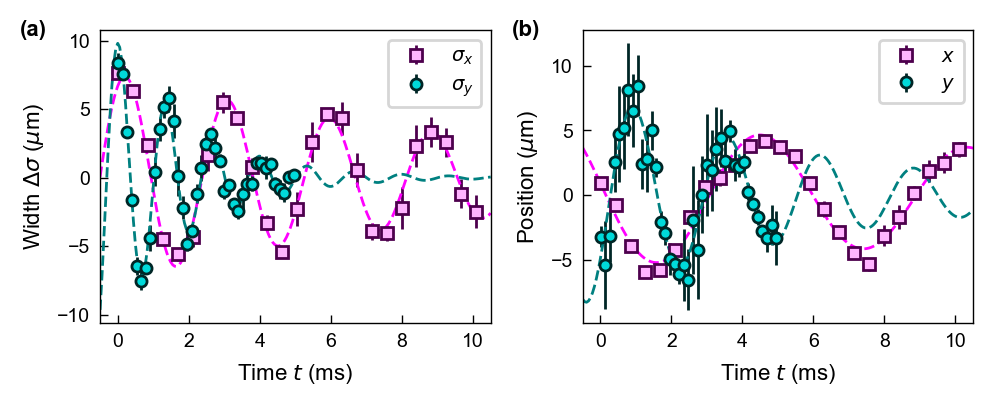

In [111]:
from scipy.optimize import curve_fit 


def trap_frequency_model(t, A, freq, phi, offset, tau):
    return A * np.exp(-t / tau) * np.cos(2 * np.pi * freq * t + phi) + offset


fig, axs = plt.subplots(1, 2, figsize=(5,2))

xlims = (-0.5, 10.5)

### breathing mode
j = 0
ax = axs[j]
xlabel = r'Time $t$ (ms)'
ylabel = r'Width $\Delta\sigma$ ($\mu$m)'
ax.set(xlabel=xlabel, ylabel=ylabel, xlim=xlims)


# sigma_x
df = df_x
x = df[scan_name]

i = 1
y_name = 'G_sigma_x'
sty, color = (styles[i], colors[i])
y = df[y_name]
ey = df['em_' + y_name]

popt, pcov = curve_fit(trap_frequency_model, x, y, 
                       sigma=ey, p0=[2, 0.4, 0, np.mean(y), 3])
perr = np.sqrt(np.diag(pcov))

print("Fit results for sigma_x:")
print(f"Frequency: {popt[1]:.4f} +/- {perr[1]:.4f} kHz")
print(f"tau: {popt[-1]:.4f} +/- {perr[-1]:.4f} ms")

ax.errorbar(x, y-popt[-2], ey, **sty, label=r'$\sigma_x$')

popt[-2] = 0  # shift offset to zero for plotting

x_fit = np.linspace(*xlims, 200)
y_fit = trap_frequency_model(x_fit, *popt)
ax.plot(x_fit, y_fit, color=color, linestyle='--')



# sigma_y
df = df_y
x = df[scan_name]

i = 0
y_name = 'G_sigma_y'
sty, color = (styles[i], colors[i])
y = df[y_name]
ey = df['em_' + y_name]

popt, pcov = curve_fit(trap_frequency_model, x, y, 
                       sigma=ey, p0=[2, 0.8, 0, np.mean(y), 10])
perr = np.sqrt(np.diag(pcov))

print("Fit results for sigma_y:")
print(f"Frequency: {popt[1]:.4f} +/- {perr[1]:.4f} kHz")
print(f"tau: {popt[-1]:.4f} +/- {perr[-1]:.4f} ms")

ax.errorbar(x, y-popt[-2], ey, **sty, label=r'$\sigma_y$')

popt[-2] = 0  # shift offset to zero for plotting

x_fit = np.linspace(*xlims, 200)
y_fit = trap_frequency_model(x_fit, *popt)
ax.plot(x_fit, y_fit, color=color, linestyle='--')

ax.legend()



### oscillation mode
ax = axs[1]
xlabel = r'Time $t$ (ms)'
ylabel = r'Position ($\mu$m)'
ax.set(xlabel=xlabel, ylabel=ylabel, xlim=xlims)


# x
df = df_x
x = df[scan_name]

i = 1
y_name = 'G_ctr_x'
sty, color = (styles[i], colors[i])
y = df[y_name]
ey = df['em_' + y_name]

popt, pcov = curve_fit(trap_frequency_model, x, y, p0=[2, 0.5, 0, np.mean(y), 5])
perr = np.sqrt(np.diag(pcov))

print("Fit results for x:")
print(f"Frequency: {popt[1]:.4f} +/- {perr[1]:.4f} kHz")
print(f"tau: {popt[-1]:.4f} +/- {perr[-1]:.4f} ms")

ax.errorbar(x, y-popt[-2], ey, **sty, label=r'$x$')

popt[-2] = 0  # shift offset to zero for plotting

x_fit = np.linspace(*xlims, 200)
y_fit = trap_frequency_model(x_fit, *popt)
ax.plot(x_fit, y_fit, color=color, linestyle='--')


# y
df = df_y
x = df[scan_name]

i = 0
y_name = 'G_ctr_y'
sty, color = (styles[i], colors[i])
y = df[y_name]
ey = df['em_' + y_name]

popt, pcov = curve_fit(trap_frequency_model, x, y, 
                       sigma=ey, 
                       p0=[3, 0.2, 0, np.mean(y), 5])
perr = np.sqrt(np.diag(pcov))

print("Fit results for y:")
print(f"Frequency: {popt[1]:.4f} +/- {perr[1]:.4f} kHz")
print(f"tau: {popt[-1]:.4f} +/- {perr[-1]:.4f} ms")

ax.errorbar(x, y-popt[-2], ey, **sty, label=r'$y$')

popt[-2] = 0  # shift offset to zero for plotting

x_fit = np.linspace(*xlims, 200)
y_fit = trap_frequency_model(x_fit, *popt)
ax.plot(x_fit, y_fit, color=color, linestyle='--')

ax.legend()

fig.tight_layout()

subplot_labels = ['(a)', '(b)']
x_offsets = [-0.205, -0.18]
for ax, label, x_offset in zip(axs, subplot_labels, x_offsets):
	ax.text(x_offset, 0.98, label, transform=ax.transAxes, fontweight='bold', fontsize=8)
	
plt.subplots_adjust(top=0.95)

fig.savefig("outputs/trap_frequencies.pdf")
plt.show()